<a href="https://colab.research.google.com/github/KillerStrike17/10DaysofMLChallenge/blob/master/Day5/Day5_Dog_Cat_Classifier_on_GPU_Using_Custom_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Day 5

## Import Libraries

In [1]:
!nvidia-smi

Tue Mar 31 22:00:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Code to Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#calling the Gods
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
# from kpreprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True)eras.callbacks import EarlyStopping, 
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import matplotlib.gridspec as gridspec
import scipy

## Data Extraction

In [0]:
!cp  /content/gdrive/My\ Drive/Kaggle_Competitions_Dataset/Dog_Cat_Dataset/cats_and_dogs_filtered.zip /content/

In [5]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

In [6]:
print(tf.__version__)

2.2.0-rc2


In [0]:
data_dir = pathlib.Path('/content/cats_and_dogs_filtered/train')

## Data Augmentation

In [0]:
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser
  
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
datagen = ImageDataGenerator(
      rescale=1./255, #Rescale the image
      rotation_range=40, #Rotate it
      width_shift_range=0.2, #Change the width
      height_shift_range=0.2, #Change the height
      shear_range=0.2, #Shear the image
      zoom_range=0.2, #Zoom in or zoom out
      horizontal_flip=True, #Flip the image horizontally
      fill_mode='nearest',
      preprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES                                                                      

array(['cats', 'dogs'], dtype='<U4')

In [22]:
train_it = datagen.flow_from_directory('cats_and_dogs_filtered/train/',  batch_size=256,classes = list(CLASS_NAMES),class_mode='categorical',target_size=(150,150))
# load and iterate validation dataset
val_it = val_datagen.flow_from_directory('cats_and_dogs_filtered/validation/', batch_size=256,classes = list(CLASS_NAMES),class_mode='categorical',target_size=(150,150))
# load and iterate test dataset

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Data Visualization

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

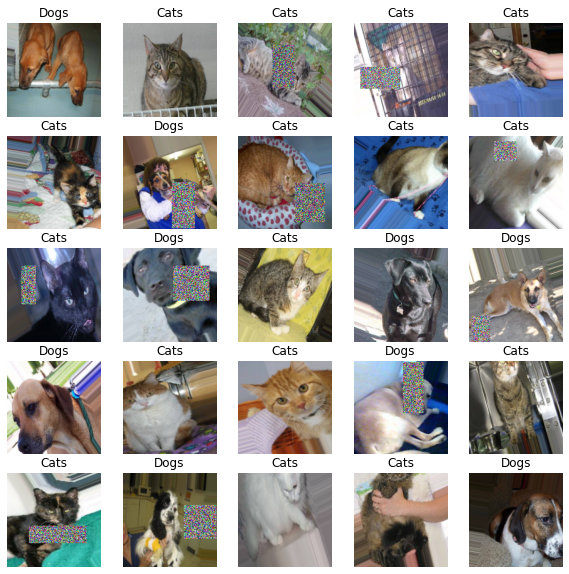

In [24]:
image_batch, label_batch = next(train_it)
show_batch(image_batch, label_batch)

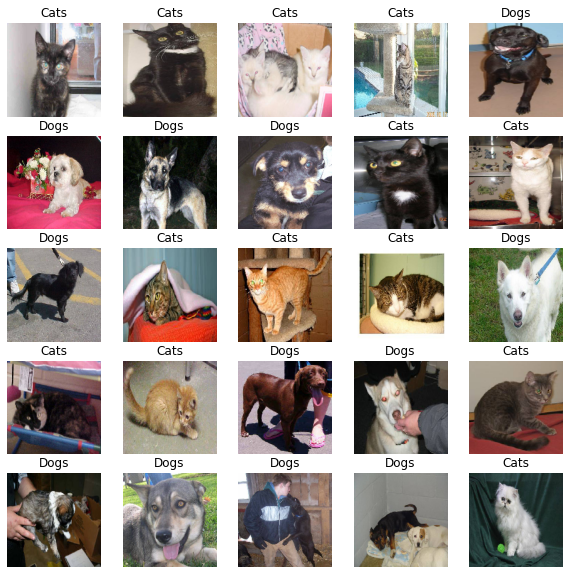

In [25]:
image_batch, label_batch = next(val_it)
show_batch(image_batch, label_batch)

In [26]:
#making the class mode binary again
train_it = datagen.flow_from_directory('cats_and_dogs_filtered/train/',  batch_size=256,classes = list(CLASS_NAMES),class_mode='binary',target_size=(150,150))
# load and iterate validation dataset
val_it = val_datagen.flow_from_directory('cats_and_dogs_filtered/validation/', batch_size=256,classes = list(CLASS_NAMES),class_mode='binary',target_size=(150,150))
# load and iterate test dataset

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model Building

In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256,(1,1), activation='relu'),
    tf.keras.layers.Conv2D(128,(1,1), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 15, 15, 128)      

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [47]:
history = model.fit_generator(
      train_it,
      steps_per_epoch=100,
      epochs=15,
      validation_data=val_it,
      validation_steps=50,
      verbose=1,callbacks =[learning_rate_reduction])

Epoch 1/15
100/100 [==============================] - 214s 2s/step - loss: 0.6893 - acc: 0.5364 - val_loss: 0.6746 - val_acc: 0.5639 - lr: 1.0000e-04
Epoch 2/15
100/100 [==============================] - 212s 2s/step - loss: 0.6764 - acc: 0.5714 - val_loss: 0.6519 - val_acc: 0.6201 - lr: 1.0000e-04
Epoch 3/15
100/100 [==============================] - 212s 2s/step - loss: 0.6650 - acc: 0.5889 - val_loss: 0.6362 - val_acc: 0.6732 - lr: 1.0000e-04
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.6081
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
100/100 [==============================] - 212s 2s/step - loss: 0.6551 - acc: 0.6081 - val_loss: 0.6247 - val_acc: 0.6670 - lr: 1.0000e-04
Epoch 5/15
100/100 [==============================] - ETA: 0s - loss: 0.6417 - acc: 0.6248
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
100/100 [==============================] - 216s 2s/step - loss: 0.641

## Results Visualization

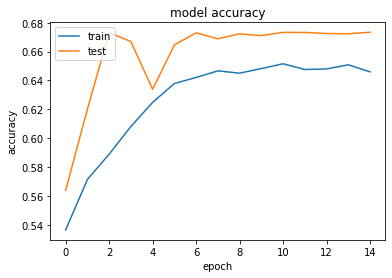

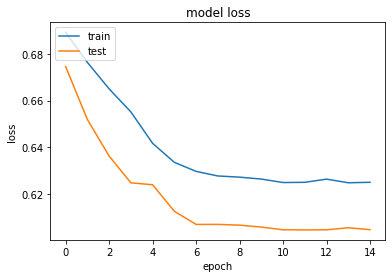

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()